## 1. Import Libraries

In [1]:
import tensorflow as tf 
import tensorflow_datasets as tfds 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm  

## Data Preprocess
### 2(a). Load and Preprocess Data

In [2]:
train_data, info = tfds.load("fashion_mnist", split="train", data_dir='./data/', with_info=True, download=False)
test_data = tfds.load('fashion_mnist', split='test', data_dir='./data/', download=False)

class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='./data/fashion_mnist\\3.0.1',
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
               

### 2(b). Normalize the data
- Flatten stem will convert 28*28 image to 784*1
- Normalize step will convert the image from range(0,255) -> range(0,1)

In [3]:
def format_img(data):
    image = data['image']
    image = tf.reshape(image, [-1]) #flattend to 1-D array 
    image = tf.cast(image, 'float32') # changed dtype
    image = image / 255.0 #normalize from range(0,255)->range(0,1)
    return image, data['label']

### 2(c). Mapping the normalized version to the train and test set.

In [4]:
train_data = train_data.map(format_img)
test_data = test_data.map(format_img)

### 2(d). Create batches

In [5]:
train = train_data.shuffle(buffer_size=1024).batch(64)
test = test_data.batch(64)

## 3. Building the Model.
### 3(a). Define the Model.

In [6]:
def base_model():
    inputs = tf.keras.Input(shape=(784,), name='digits')
    dense1 = tf.keras.layers.Dense(64, activation='relu', name='dense1')(inputs)
    dense2 = tf.keras.layers.Dense(64, activation='relu', name='dense2')(dense1)
    outputs = tf.keras.layers.Dense(10, activation='softmax', name='predictions')(dense2)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
digits (InputLayer)          [(None, 784)]             0         
_________________________________________________________________
dense1 (Dense)               (None, 64)                50240     
_________________________________________________________________
dense2 (Dense)               (None, 64)                4160      
_________________________________________________________________
predictions (Dense)          (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________
None


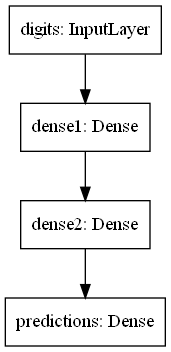

In [7]:
model = base_model()
print(model.summary())
tf.keras.utils.plot_model(model)

### 3(b). Define optimizer and loss function

In [8]:
optimizer = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()

### 3(c). Define Metrics

In [9]:
train_acc_metrics = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metrics = tf.keras.metrics.SparseCategoricalAccuracy()

## 4. Building the Training loop
### 4(a). Build the apply_gradient().

### 4(a). Defining training data loop per epoch.
- Apply_Gradient(): is used for calculating the gradients , for the optimizer in the Back propagation step. So it is only needed in training step.
-  The metrics are accumulated.

In [10]:
def trainingPerEpoch():
    losses = []
    pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}')

    for step, (x_train_batch, y_train_batch) in enumerate(train):
        ### Apply_Gradient():
        # Calculate the loss, gradients and update the parameters
        with tf.GradientTape() as tape:
            train_logits = model(x_train_batch)
            train_loss = loss_func(y_true=y_train_batch, y_pred=train_logits)
        gradient = tape.gradient(train_loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradient, model.trainable_weights))
        losses.append(train_loss)

        # update metrics
        train_acc_metrics(y_train_batch, train_logits)

        pbar.set_description(f'Training loss for step {step}: {train_loss:.2f}')
        pbar.update()
    return losses

### 4(b). Defining the validation loop per epoch.

In [11]:
def validationPerEpoch():
    val_losses = []
    for x_batch_test, y_batch_test in test:
        val_logits = model(x_batch_test)
        val_loss = loss_func(y_true=y_batch_test, y_pred=val_logits)
        val_losses.append(val_loss)
        val_acc_metrics(y_batch_test, val_logits)
    return val_losses

### 4(c). build the model and train.

In [12]:
model = base_model()
perEpoch_trainLosses, perEpoch_valLosses = [], []
epochs = 10
for epoch in range(epochs):
    [print('=', sep='', end='', flush=True) for _ in range(0,150)]
    print(f'\nStarting of epoch={epoch}')
    train_losses = trainingPerEpoch()
    train_acc = train_acc_metrics.result()

    val_losses = validationPerEpoch()
    val_acc = val_acc_metrics.result()

    train_losses_mean, val_losses_mean = np.mean(train_losses), np.mean(val_losses)
    perEpoch_trainLosses.append(train_losses_mean)
    perEpoch_valLosses.append(val_losses_mean)

    print(f'\nEpoch : {epoch}|Training Loss : {train_losses_mean:.2f}|Validation Loss : {val_losses_mean:.2f}|Training Accuracy : {train_acc:.2f}|Validation Accuracy : {val_acc:.2f}')
    
    train_acc_metrics.reset_states()
    val_acc_metrics.reset_states()

Starting of epoch=0
Training loss for step 937: 0.43: 100%|█████████▉| 937/938
Epoch : 0|Training Loss : 0.54|Validation Loss : 0.45|Training Accuracy : 0.81|Validation Accuracy : 0.84
Starting of epoch=1
Training loss for step 937: 0.30: 100%|█████████▉| 937/938
Epoch : 1|Training Loss : 0.39|Validation Loss : 0.40|Training Accuracy : 0.86|Validation Accuracy : 0.86
Starting of epoch=2
Training loss for step 937: 0.30: 100%|██████████| 938/938
Training loss for step 937: 0.17: 100%|█████████▉| 937/938
Epoch : 2|Training Loss : 0.35|Validation Loss : 0.40|Training Accuracy : 0.87|Validation Accuracy : 0.85
Starting of epoch=3
Training loss for step 937: 0.43: 100%|██████████| 938/938
Training loss for step 937: 0.17: 100%|██████████| 938/938
Training loss for step 937: 0.29: 100%|██████████| 938/938
Epoch : 3|Training Loss : 0.33|Validation Loss : 0.38|Training Accuracy : 0.88|Validation Accuracy : 0.87
Starting of epoch=4
Training loss for step 937: 0.12: 100%|█████████▉| 937/938
Epoc

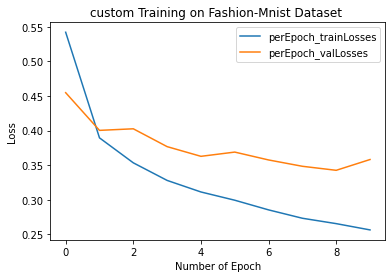

In [22]:
plt.title('custom Training on Fashion-Mnist Dataset ')
plt.plot(perEpoch_trainLosses, label='perEpoch_trainLosses')
plt.plot(perEpoch_valLosses, label='perEpoch_valLosses')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

[0.4457422, 0.3956761, 0.3821968]

In [1]:
import tensorflow as tf
strat = tf.distribute.MirroredStrategy()
print(f'{strat.num_replicas_in_sync}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
1
